<a href="https://colab.research.google.com/github/BISHALSAHA21/ARTIFICIAL-INTELLIGENCE-AND-MACHINE_LEARNING/blob/main/Extra_Content_Image_Generation_Based_on_Stable_Diffusion_and_Facial_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade diffusers transformers -q
!pip install -q face_recognition
!pip install -q fer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from pathlib import Path
import tqdm
import torch
import pandas as pd
import numpy as np
from diffusers import StableDiffusionPipeline
from transformers import pipeline, set_seed
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import ImageDraw
from io import BytesIO
import face_recognition
import time
from google.colab import files
from google.colab.patches import cv2_imshow

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
class CFG:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    seed = 42
    generator = torch.Generator(device).manual_seed(seed)
    image_gen_steps = 35
    image_gen_model_id = "stabilityai/stable-diffusion-2"
    image_gen_size = (400, 400)
    image_gen_guidance_scale = 9
    prompt_gen_model_id = "gpt2"
    prompt_dataset_size = 6
    prompt_max_length = 12


In [ ]:
def generate_image(prompt, model, original_image):
    image = model(
        prompt,
        num_inference_steps=CFG.image_gen_steps,
        generator=CFG.generator,
        guidance_scale=CFG.image_gen_guidance_scale,
        init_image=original_image
    ).images[0]

    image = image.resize(CFG.image_gen_size)
    return image


In [ ]:
def display_image_with_faces(image_path, face_locations):
    im = plt.imread(image_path)
    height = (im.shape[0] / im.shape[1]) * 20
    fig, ax = plt.subplots(figsize=(20, height))
    ax.imshow(im)
    for face_location in face_locations:
        top, right, bottom, left = face_location
        rect = patches.Rectangle((left, top), (right - left), (bottom - top), linewidth=3, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.axis('off')
    plt.show()

In [ ]:
def get_person_name():
    return input("Please enter the name of the person: ")

In [ ]:
image_gen_model = StableDiffusionPipeline.from_pretrained(
    CFG.image_gen_model_id,
    torch_dtype=torch.float16,
    revision="fp16",
    use_auth_token='your_hugging_face_auth_token',
    guidance_scale=9
)
image_gen_model = image_gen_model.to(CFG.device)


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/511 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:212: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
text_encoder/model.safetensors not found


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/815 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/900 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

Keyword arguments {'use_auth_token': 'your_hugging_face_auth_token', 'guidance_scale': 9} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
from PIL import Image


In [ ]:
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
original_image = Image.open(image_path)


Saving Amitabh Bachchan.jpg to Amitabh Bachchan (4).jpg


In [ ]:
image = face_recognition.load_image_file(image_path)
face_locations = face_recognition.face_locations(image)

In [ ]:
display_image_with_faces(image_path, face_locations)

In [ ]:
person_name = get_person_name()

Please enter the name of the person: Amitabh Bachchan


  0%|          | 0/35 [00:00<?, ?it/s]

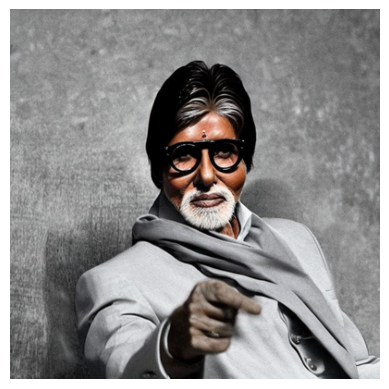

In [ ]:
generated_image = generate_image(person_name, image_gen_model, original_image)
plt.imshow(generated_image)
plt.axis('off')
plt.show()


In [ ]:
def display_image_comparison(original_image, generated_image):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(generated_image)
    axes[1].set_title('Generated Image')
    axes[1].axis('off')
    plt.show()

In [ ]:
def display_generation_progress(image_sequence):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(range(len(image_sequence)), image_sequence, marker='o', linestyle='-')
    ax.set_xlabel('Step')
    ax.set_ylabel('Image Quality')
    ax.set_title('Image Generation Progress')
    plt.grid(True)
    plt.show()

In [ ]:
generated_image_sequence = []
for step in tqdm.tqdm(range(CFG.image_gen_steps)):
    generated_image = generate_image(person_name, image_gen_model, original_image)
    generated_image_sequence.append(generated_image)

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  3%|▎         | 1/35 [00:11<06:40, 11.79s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

  6%|▌         | 2/35 [00:23<06:31, 11.86s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:35<06:22, 11.96s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 11%|█▏        | 4/35 [00:48<06:14, 12.08s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 14%|█▍        | 5/35 [01:00<06:04, 12.16s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 17%|█▋        | 6/35 [01:12<05:55, 12.26s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 20%|██        | 7/35 [01:25<05:46, 12.36s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 23%|██▎       | 8/35 [01:37<05:35, 12.41s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 26%|██▌       | 9/35 [01:50<05:22, 12.40s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 29%|██▊       | 10/35 [02:02<05:09, 12.38s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 31%|███▏      | 11/35 [02:14<04:56, 12.37s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 34%|███▍      | 12/35 [02:27<04:44, 12.38s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 37%|███▋      | 13/35 [02:39<04:32, 12.40s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 40%|████      | 14/35 [02:52<04:20, 12.42s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 43%|████▎     | 15/35 [03:04<04:08, 12.44s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 46%|████▌     | 16/35 [03:17<03:56, 12.44s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 49%|████▊     | 17/35 [03:29<03:43, 12.44s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 51%|█████▏    | 18/35 [03:42<03:31, 12.42s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 54%|█████▍    | 19/35 [03:54<03:18, 12.42s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 57%|█████▋    | 20/35 [04:06<03:06, 12.42s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 60%|██████    | 21/35 [04:19<02:53, 12.41s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 63%|██████▎   | 22/35 [04:31<02:41, 12.40s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 66%|██████▌   | 23/35 [04:44<02:28, 12.40s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 69%|██████▊   | 24/35 [04:56<02:16, 12.40s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 71%|███████▏  | 25/35 [05:08<02:04, 12.41s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 74%|███████▍  | 26/35 [05:21<01:51, 12.42s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 77%|███████▋  | 27/35 [05:33<01:39, 12.42s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 80%|████████  | 28/35 [05:46<01:27, 12.43s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 83%|████████▎ | 29/35 [05:58<01:14, 12.45s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 86%|████████▌ | 30/35 [06:11<01:02, 12.46s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 89%|████████▊ | 31/35 [06:23<00:49, 12.47s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 91%|█████████▏| 32/35 [06:36<00:37, 12.48s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 94%|█████████▍| 33/35 [06:48<00:24, 12.48s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

 97%|█████████▋| 34/35 [07:01<00:12, 12.47s/it]

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [07:13<00:00, 12.39s/it]


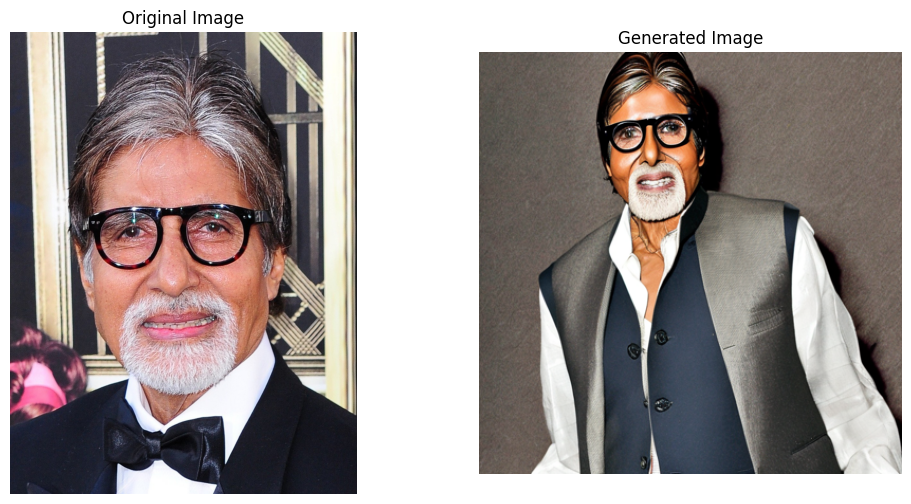

In [ ]:
display_image_comparison(original_image, generated_image_sequence[-1])